In [1]:
from threading import Thread
import numpy as np
import cv2
from __future__ import print_function
import glob
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from AntiInstagram import AntiInstagram
from collections import namedtuple
from duckietown_msgs.msg import Pixel
import duckietown_utils as dtu
from geometry_msgs.msg import Point

/usr/local/lib/python2.7/dist-packages/geometry/__init__.py:18: UserWarning: Scipy not found -- needed for functions logm, expm, eigh. I will go on without it, but later an error will be thrown if those functions are used.
  warnings.warn(msg)


In [2]:
def bgrshow(bgr):
    imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
def imshow(img):
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.imshow(img)
    plt.show()

In [3]:
hsv_white1 =  np.array([0,0,150])
hsv_white2 =  np.array([180,60,255])
hsv_yellow1 = np.array([25,140,100])
hsv_yellow2 = np.array([45,255,255])
hsv_red1 =    np.array([0,140,100])
hsv_red2 =    np.array([15,255,255])
hsv_red3 =    np.array([165,140,100])
hsv_red4 =    np.array([180,255,255])

dilation_kernel_size = 3

ColorFilteredImage = namedtuple('ColorFilteredImage', 'patches edges')

def colorFilter(hsv, edges, color):
    # threshold colors in HSV space
    if color == 'white':
        bw = cv2.inRange(hsv, hsv_white1, hsv_white2)
    elif color == 'yellow':
        bw = cv2.inRange(hsv, hsv_yellow1, hsv_yellow2)
    elif color == 'red':
        bw1 = cv2.inRange(hsv, hsv_red1, hsv_red2)
        bw2 = cv2.inRange(hsv, hsv_red3, hsv_red4)
        bw = cv2.bitwise_or(bw1, bw2)
    # binary dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(dilation_kernel_size, dilation_kernel_size))

    # refine edge for certain color
    edge_color = cv2.bitwise_and(cv2.dilate(bw, kernel), edges)

    return ColorFilteredImage(bw, edge_color)

In [4]:
canny_thresholds = [80, 200]

def findEdge(img):
    edges = cv2.Canny(img, canny_thresholds[0], canny_thresholds[1], apertureSize = 3)
    return edges

In [5]:
def process(img):
    cbimage = ai.apply_color_balance(img, output_scale)
    hsv = cv2.cvtColor(cbimage, cv2.COLOR_BGR2HSV)
    edges = findEdge(hsv)
    return colorFilter(hsv, edges, 'red')

In [6]:
# PROCESS ALL IMAGES AND STORE THEM IN ARRAYS
compressed = []
cutoff = 180
raw = []
for im_path in sorted(glob.glob("frames/*.png")):
    bgr = cv2.imread(im_path,cv2.IMREAD_COLOR)
    raw.append(bgr)
    compressed.append(bgr[cutoff:,:,:])

antiig = []
reds = []
output_scale = 1
color_balance_percentage = 0.8
ai = AntiInstagram()

if len(compressed)>0:
    ai.calculate_color_balance_thresholds(compressed[0], output_scale, color_balance_percentage)
    print("setup AI filter")
    
for img in compressed:
    reds.append(process(img))
    
print("Filtered "+str(len(reds))+" images")

setup AI filter
Filtered 30 images


In [7]:
H = np.array([-3.589767590401803e-05, -0.00023491693147080584, -0.1374201532070648,
  0.0008247535901185687, -5.00225097638814e-06, -0.2685590146427659, -5.664504414708967e-05,
  -0.006300114132830898, 1.0])
H = np.reshape(H,(3,3))

@dtu.contract(point=Point, returns=Pixel)
def ground2pixel(point):
    if point.z != 0:
        msg = 'This method assumes that the point is a ground point (z=0). '
        msg += 'However, the point is (%s,%s,%s)' % (point.x, point.y, point.z)
        raise ValueError(msg)

    ground_point = np.array([point.x, point.y, 1.0])
    # An applied mathematician would cry for this
    #    image_point = np.dot(self.Hinv, ground_point)
    # A better way:
    image_point = np.linalg.solve(H, ground_point)

    image_point = image_point / image_point[2]

    pixel = Pixel()
#         if not self.rectified_input:
#             dtu.logger.debug('project3dToPixel')
#             distorted_pixel = self.pcm.project3dToPixel(image_point)
#             pixel.u = distorted_pixel[0]
#             pixel.v = distorted_pixel[1]
#         else:
    pixel.u = image_point[0]
    pixel.v = image_point[1]

    return pixel

@dtu.contract(pixel=Pixel, returns=Point)
def pixel2ground(pixel):
    uv_raw = np.array([pixel.u, pixel.v])
#   if not self.rectified_input:
#       uv_raw = self.pcm.rectifyPoint(uv_raw)
    #uv_raw = [uv_raw, 1]
    uv_raw = np.append(uv_raw, np.array([1]))
    ground_point = np.dot(H, uv_raw)
    point = Point()
    x = ground_point[0]
    y = ground_point[1]
    z = ground_point[2]
    point.x = x / z
    point.y = y / z
    point.z = 0.0
    return point

In [8]:
# Each tile is 61 cm long, I want to see a tile's worth projected.
# Centered in front of the robot
#x_r = np.array([0.123, 0.123+0.61])
#y_r = np.array([-30.5, 30.5])

# origin: (x,y) in m coordinates of the near-left corner of the square
# side:   side in m of square on the ground 
# w:    side in pixels of the output image

def ground_project2(image, origin, side, w):
    # H assumes incoming image resolution is VGA (640x480) use output_scale to fix
    # pixel at bottom center is x: 0.128 y: 0.00344677851347
    # x axis is longitudinal, y axis is to the left
    # bottom edge aligned
    # don't think backwards
    oh, ow = np.shape(image) #original width, original height
    side = float(side)
    x0 = origin[0]
    y0 = origin[1]+side/2
    res = float(w)/side #pix/m in square
    
    output = np.zeros((w, w))
    pix = Pixel()
    for row in range(oh):
        for column in range(ow):
            if image[row,column] == 0: 
                continue
            # if pixel is high find out where it belongs on our square
            
            pix.v = row/output_scale+cutoff
            pix.u = column/output_scale
            
            gnd = pixel2ground(pix)
            # now I have ground plane coordinates wrt axel frame
            # find correpsonding pixel in square ("ground pixel x and y")
            gpx = int(w-(gnd.x - x0)*res) #column
            gpy = int(-(gnd.y - y0)*res) #row

            if gpx < w and gpx >= 0 and gpy < w and gpy >= 0:
                output[gpx, gpy] = image[row, column]

    return output



/usr/lib/python2.7/dist-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


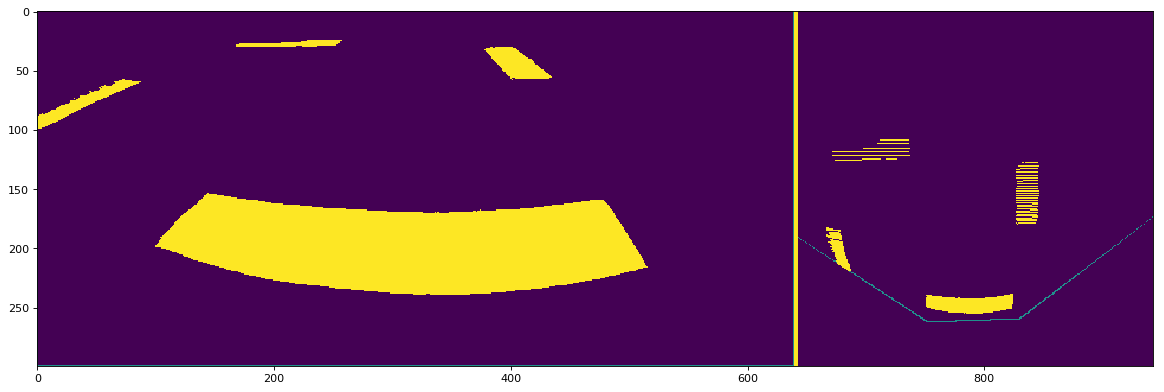

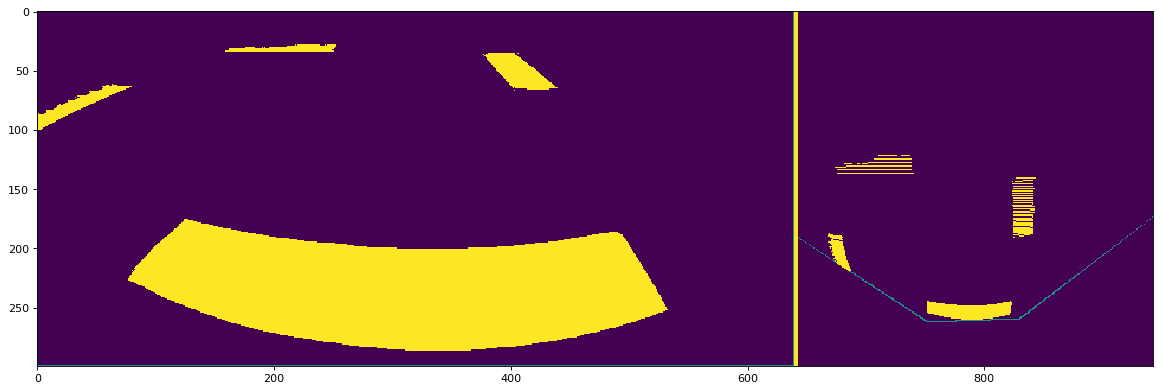

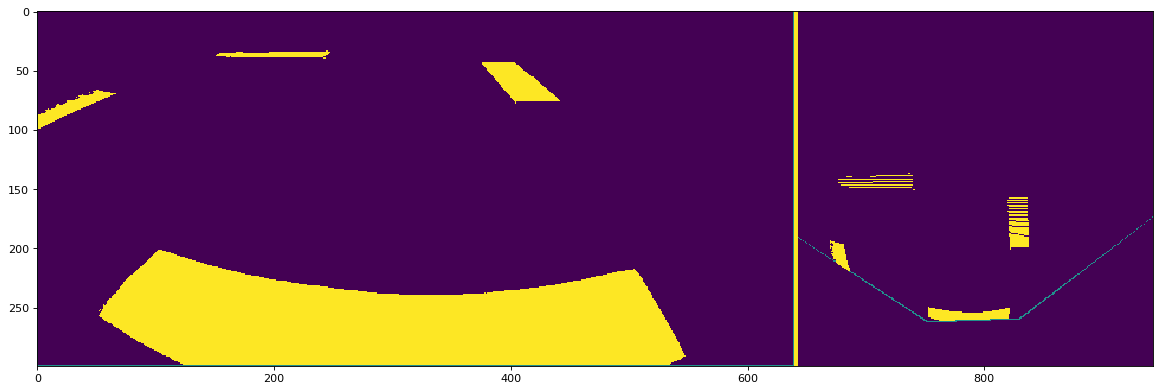

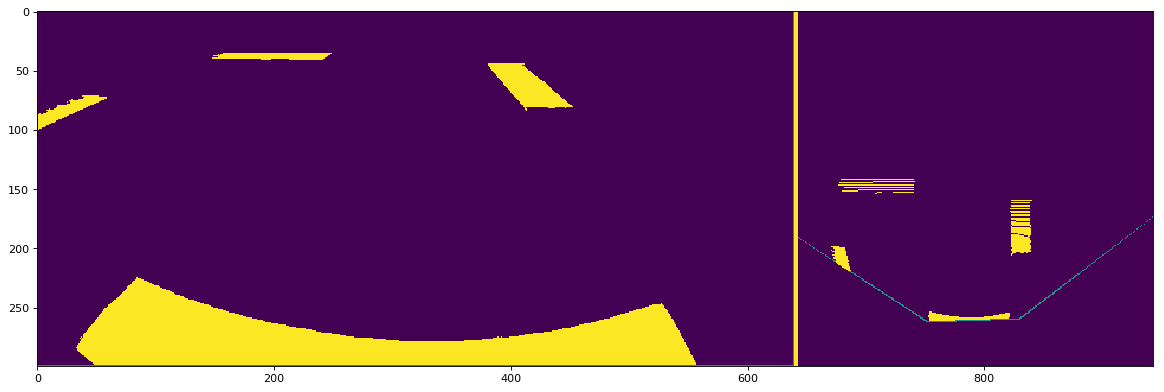

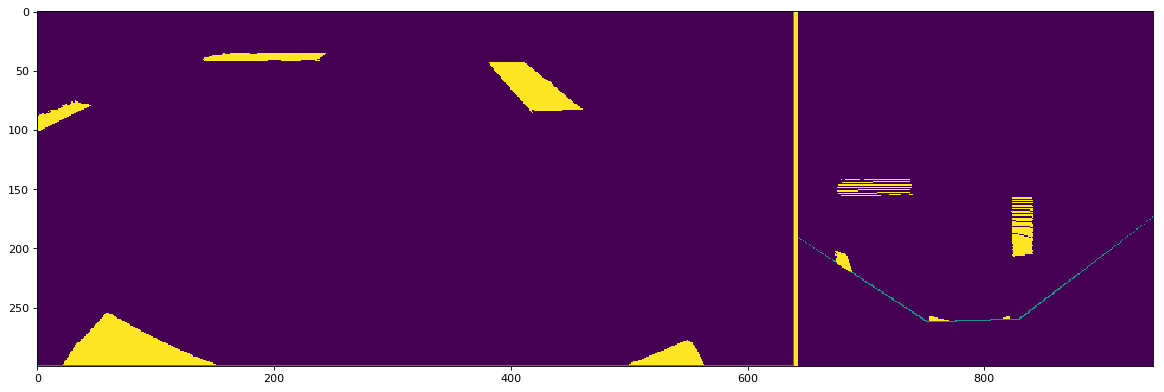

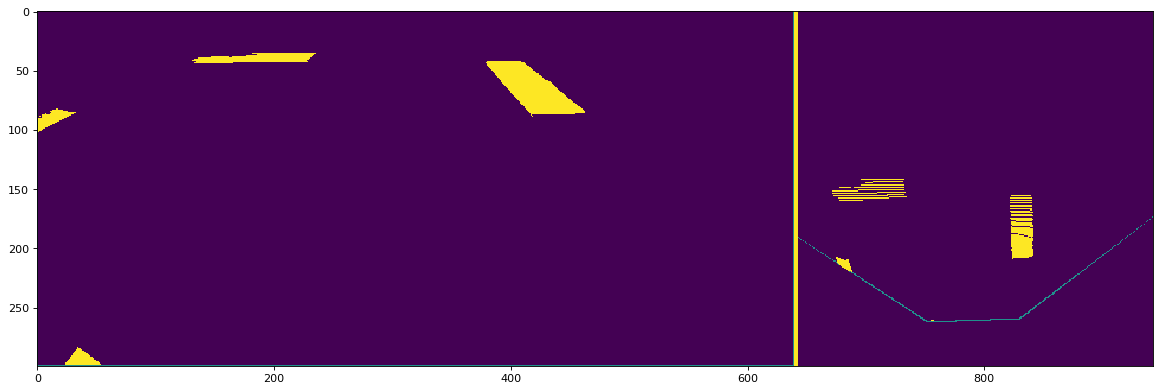

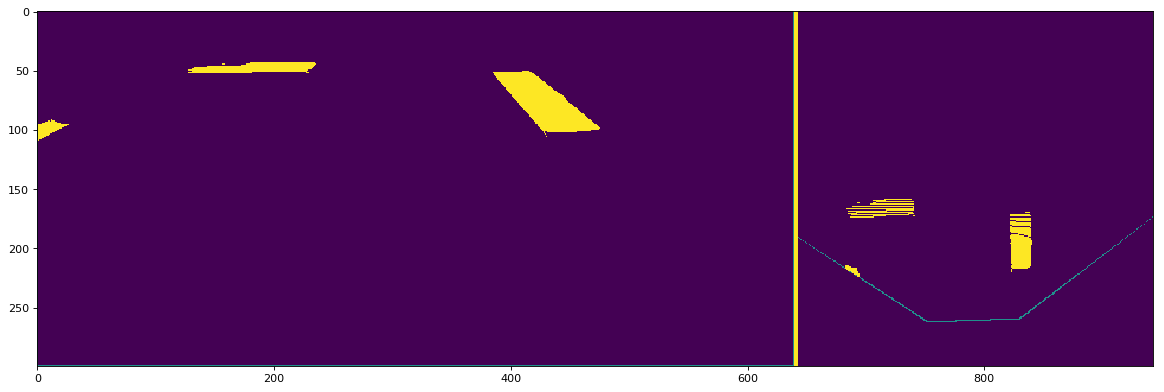

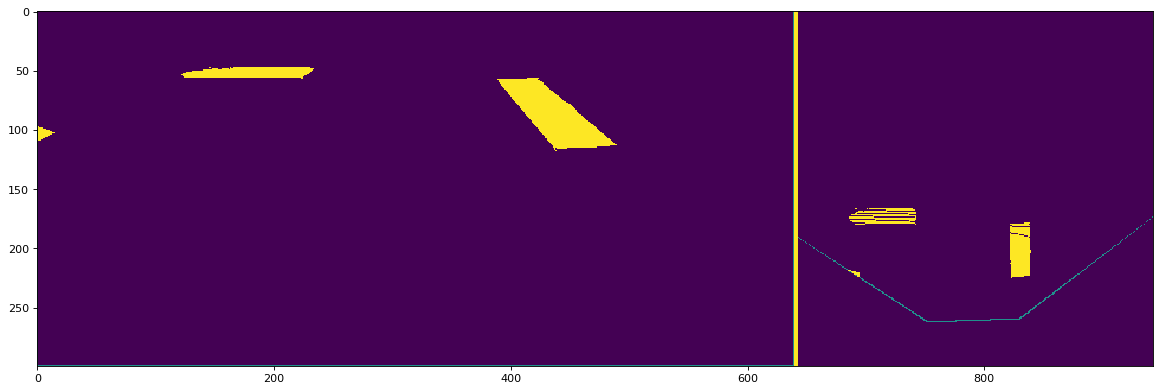

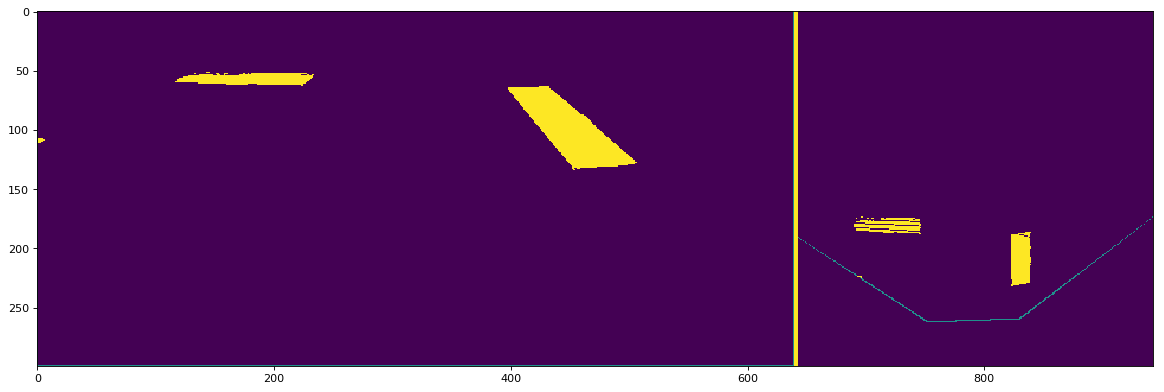

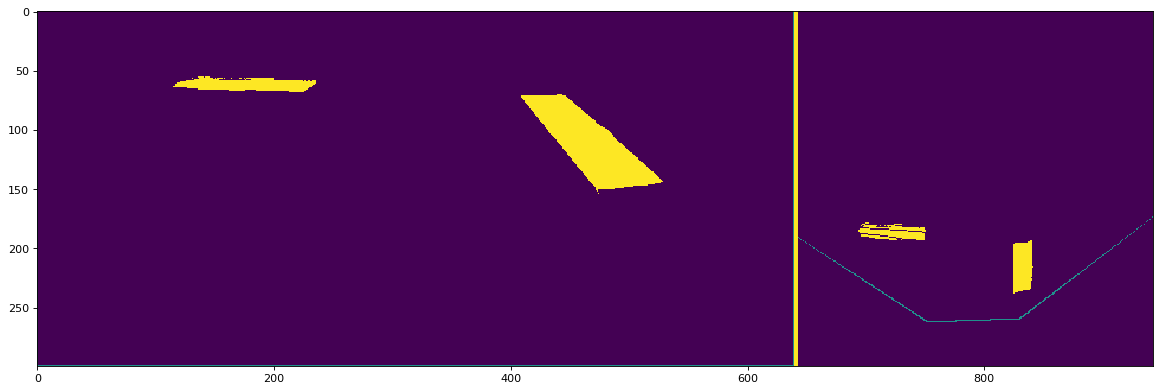

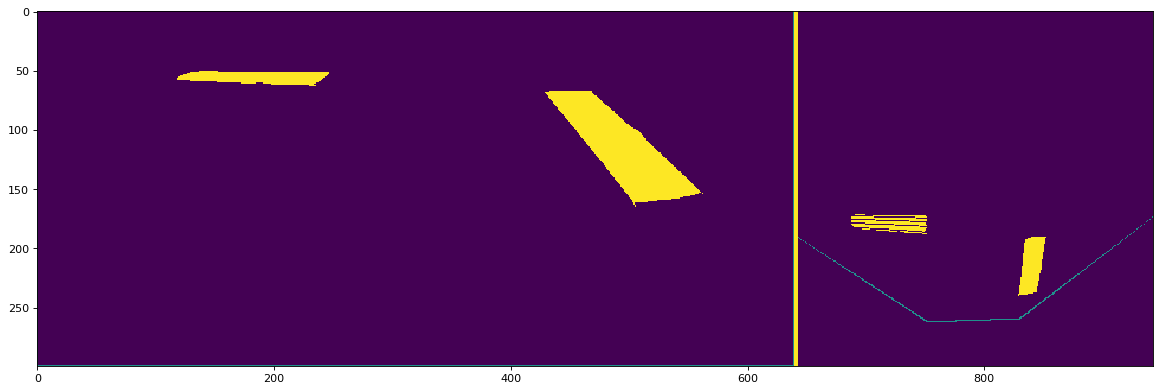

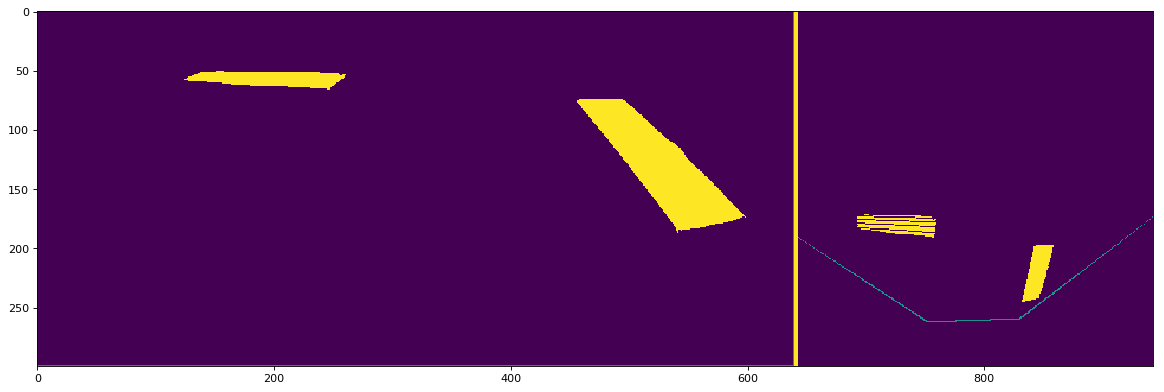

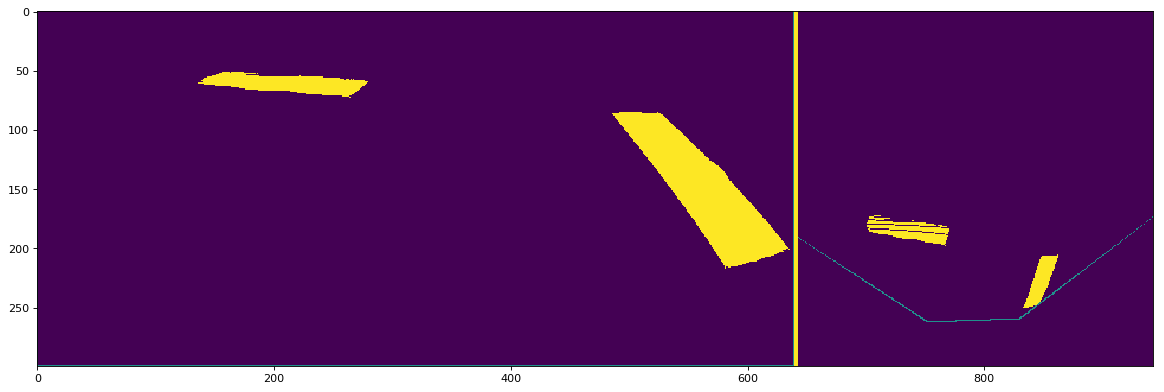

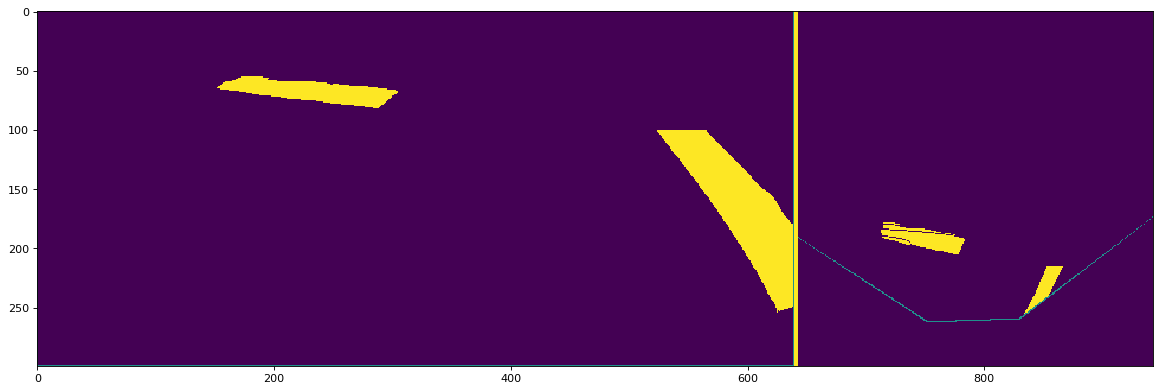

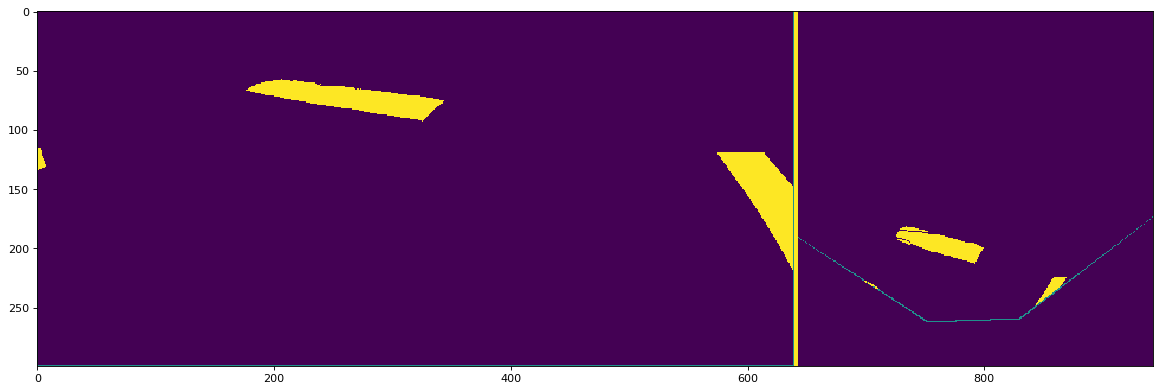

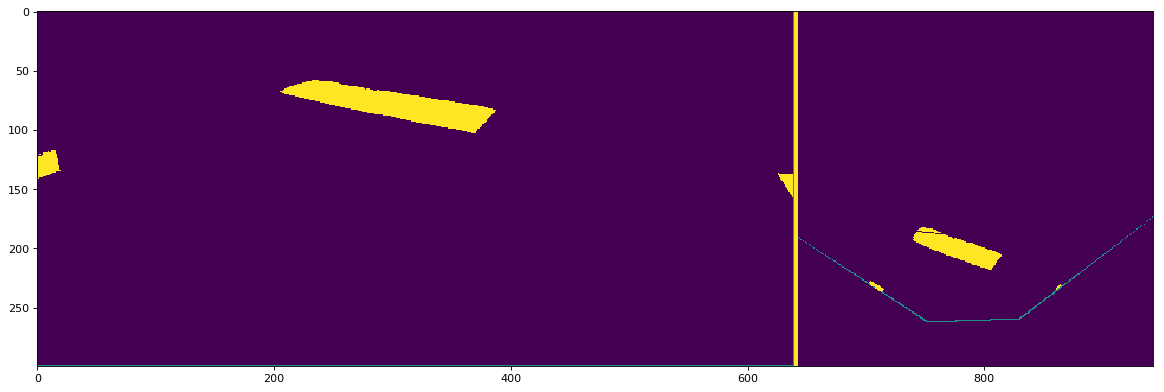

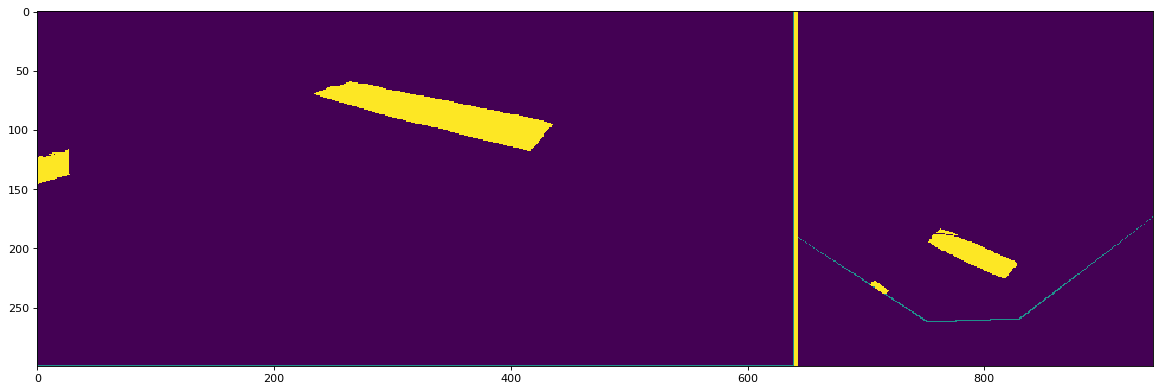

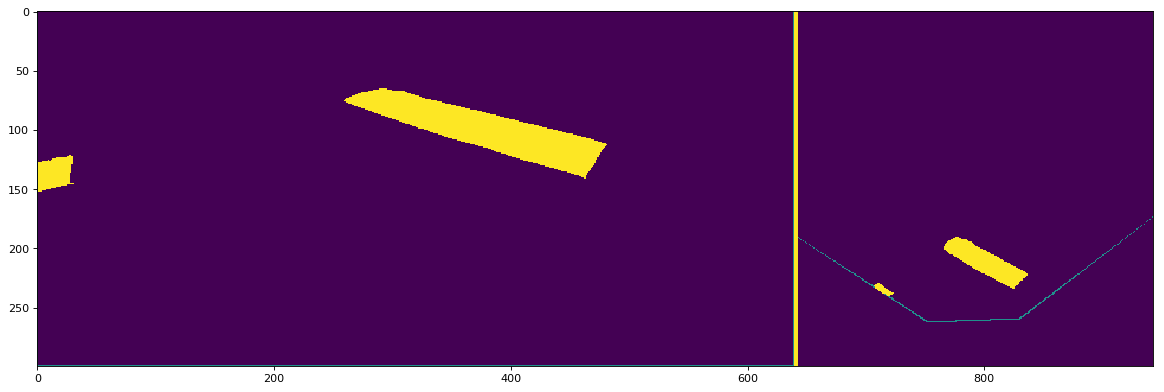

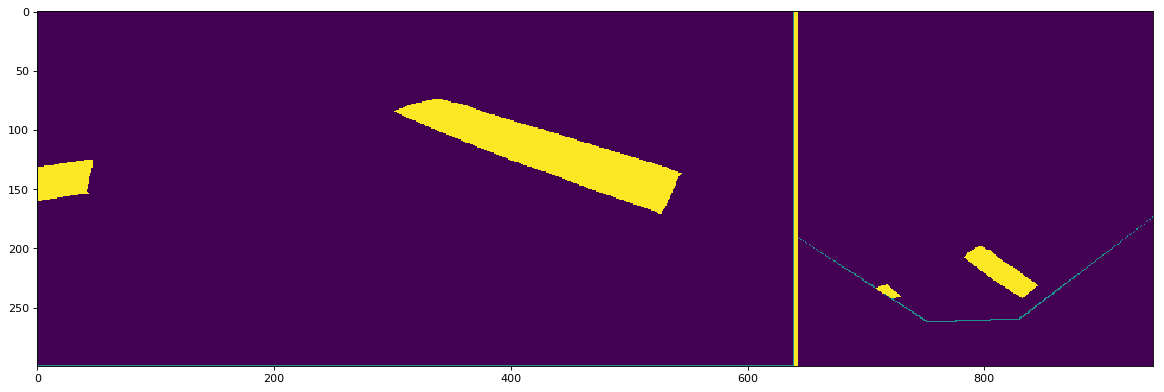

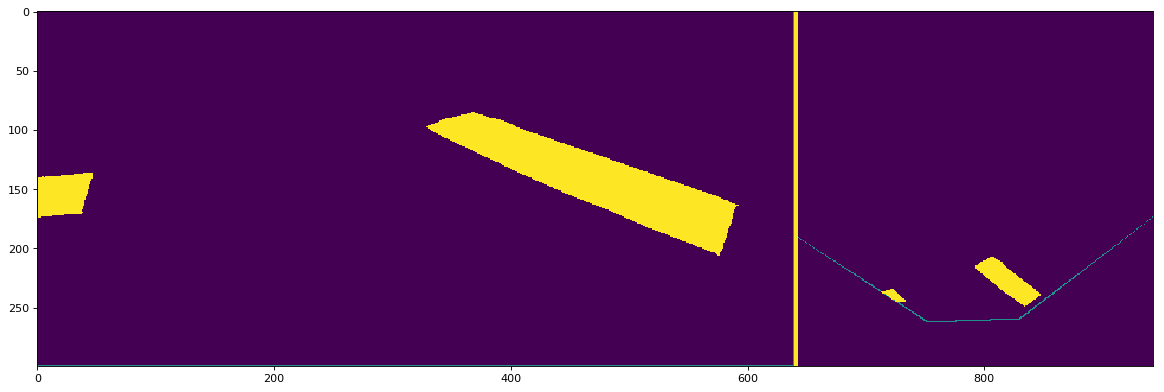

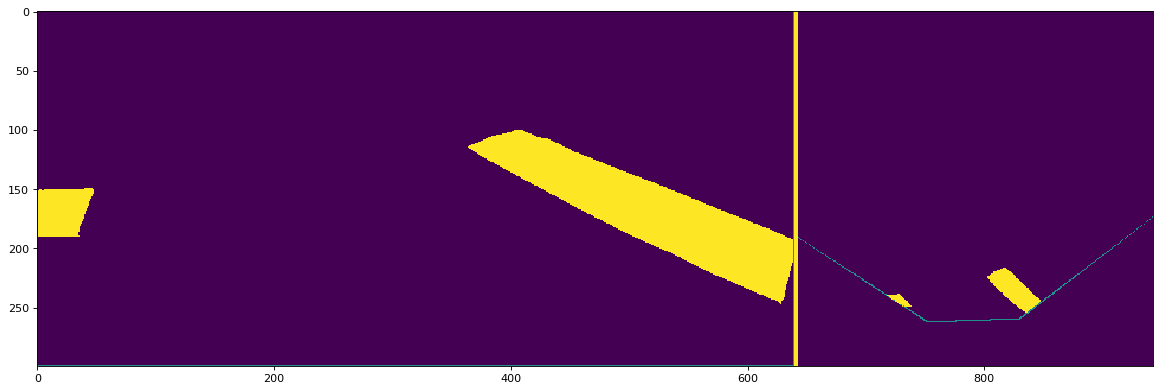

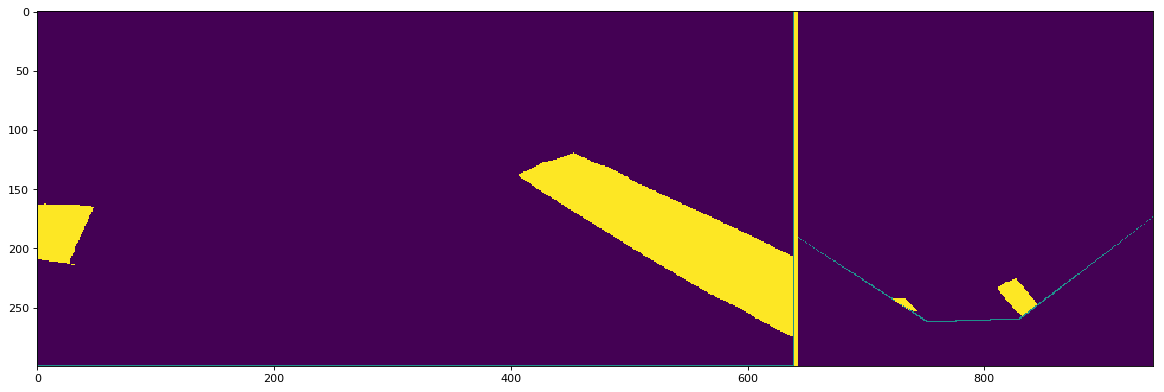

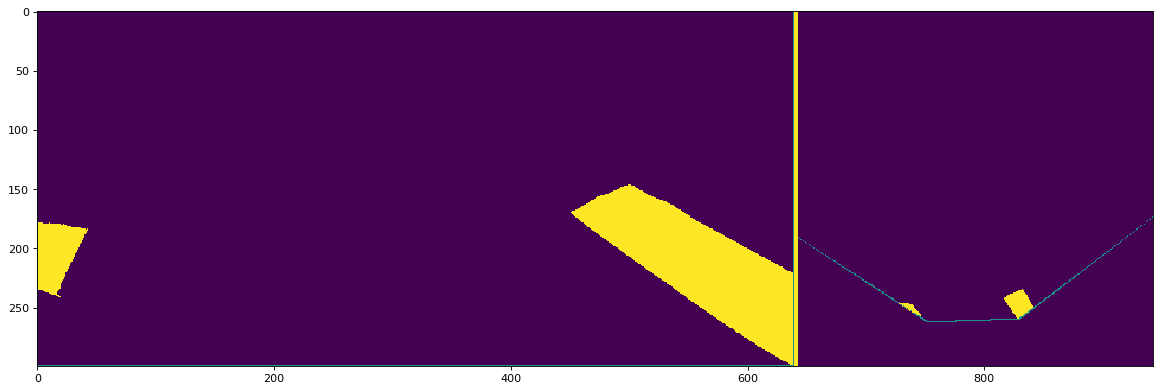

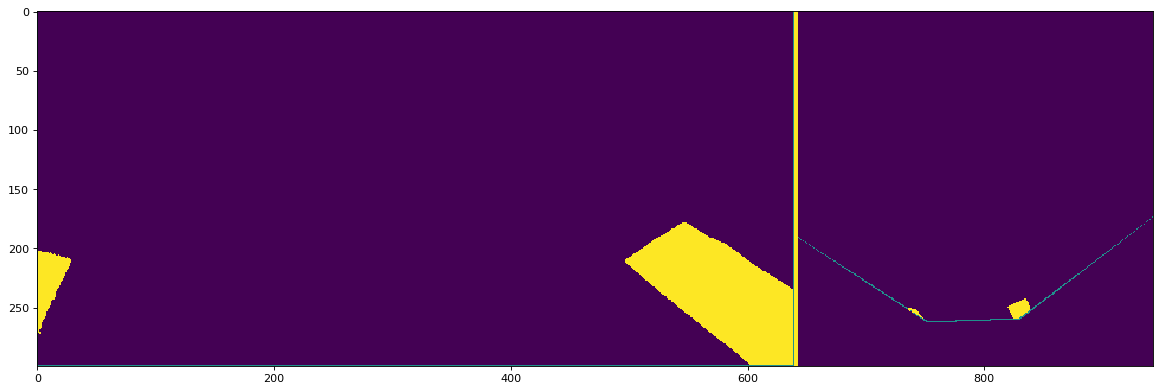

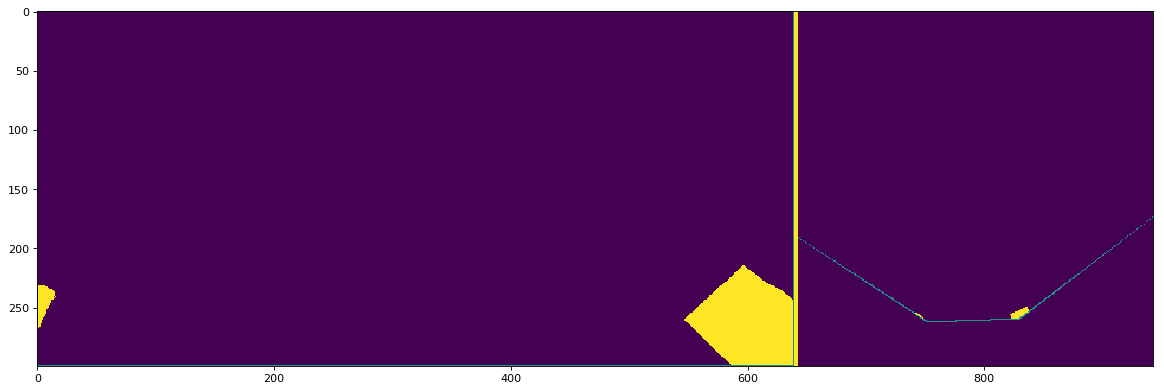

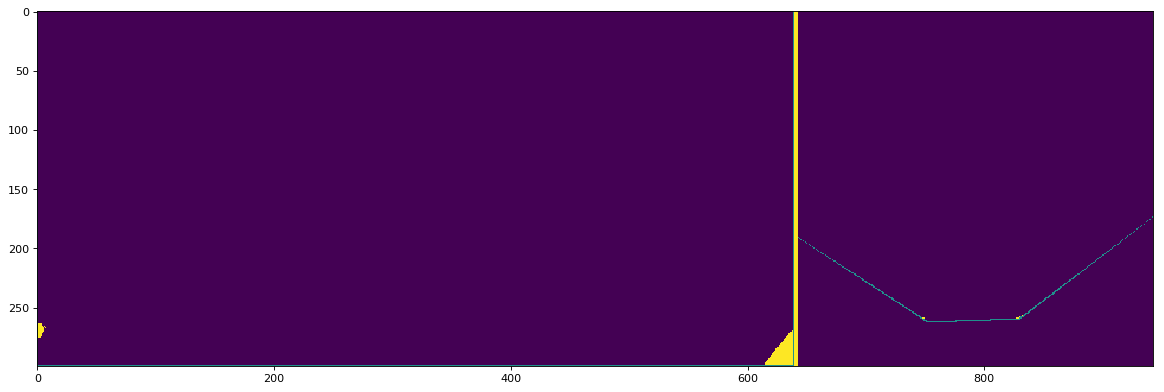

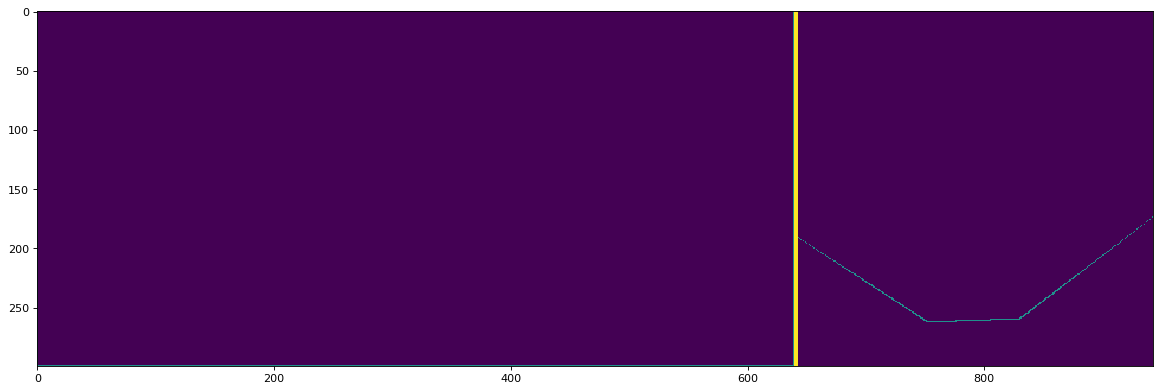

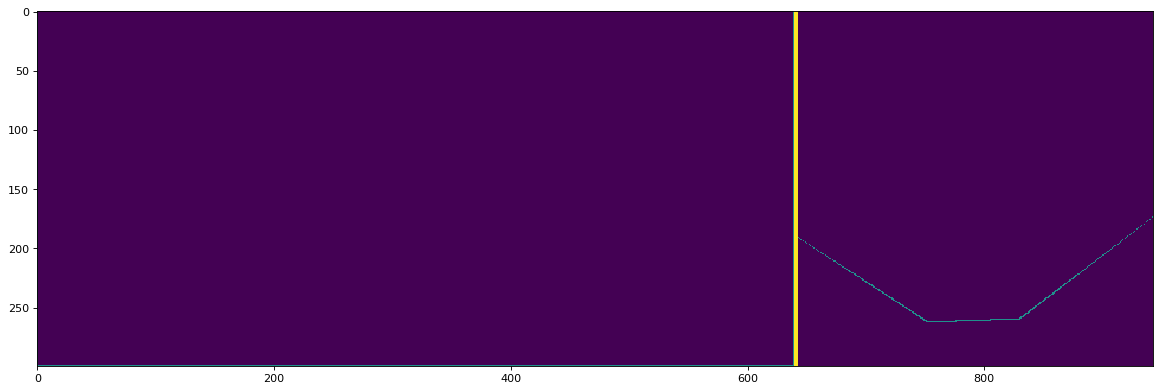

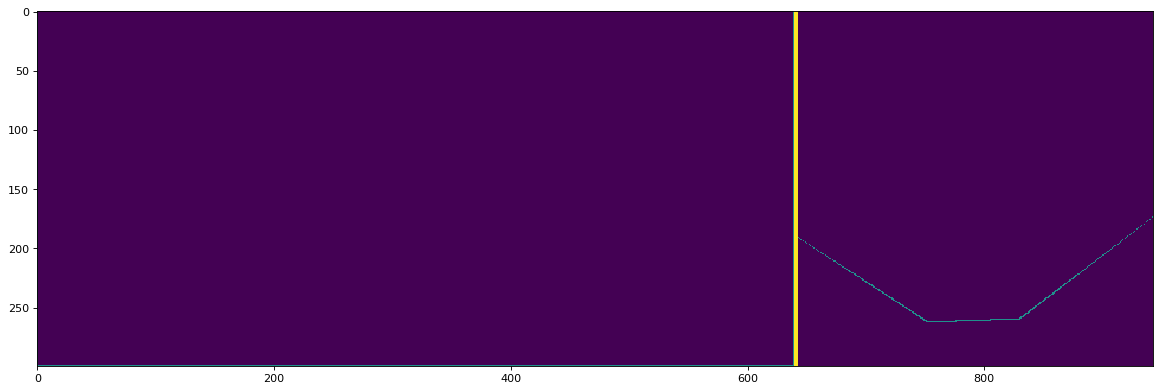

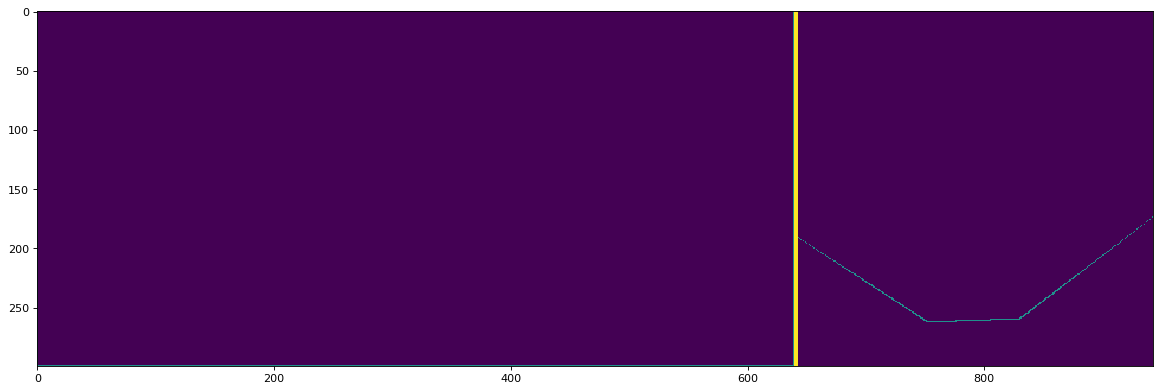

In [9]:
for red in reds:
    image = red.patches
    h, w = np.shape(image)

    #add frame to input image so we can see FOV borders in the reprojection
    image[:,(0,w-1)] = 128
    image[(0,h-1),:] = 128
    
    divider = np.ones((h,np.floor(output_scale*3)))*255

    square = ground_project2(image, [0, 0], 1, h)
    imshow(np.concatenate((image,divider,square),axis = 1))